# Energy Efficiency of Energy Star certified Refrigerators
This notebook analyzes residential refrigerator/freezer datasets from the Environmental Protection Agency's (EPA) Product Finder dataset and the Department of Energy's (DoE) in order to calculate the energy usage of Energy Star certified refrigerators/freezers compared to models that are not certified.

### Notebook Setup

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from IPython.display import display, HTML

In [3]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# set maximum number of columns to display
pd.set_option('display.max_columns', None)

# Read in Data And Drop Duplicates

The list of Energy Star certified refrigerator and freezer models is from the EPA's product finder dataset. The list of all commercially available refrigerator/freezer models is from the DoE's CCMS database.

1. Link to data sources
  - [Energy Star certified residential refrigerator database](https://data.energystar.gov/Active-Specifications/ENERGY-STAR-Certified-Residential-Refrigerators/p5st-her9/data?_gl=1*i08dcb*_ga*MzgzMzExNzM1LjE2ODcyNzUwMjU.*_ga_S0KJTVVLQ6*MTY4NzM2OTAwMi4zLjEuMTY4NzM2OTA4OC4wLjAuMA..) - Environmental Protection Agency
  - [Energy Star certified residential freezer database](https://data.energystar.gov/Active-Specifications/ENERGY-STAR-Certified-Residential-Freezers/8t9c-g3tn/data?_gl=1*yt1r8t*_ga*MzgzMzExNzM1LjE2ODcyNzUwMjU.*_ga_S0KJTVVLQ6*MTY4NzM2OTAwMi4zLjEuMTY4NzM2OTA4OC4wLjAuMA..) - Environmental Protection Agency
  - [Refrigerator Compliance Certification Database](https://www.regulations.doe.gov/certification-data/CCMS-4-Refrigerators__Refrigerator-Freezers__and_Freezers.html#q=Product_Group_s%3A%22Refrigerators%2C%20Refrigerator-Freezers%2C%20and%20Freezers%22) - Department of Energy

*Note: DoE says that even though CCMS should theoretically include all commercially available residential refrigerator/freezer models, the data may be incompletel due to various reasons. For example, if the model is approved long ago or very recently, it may not appear in the dataset. Despite the limitation, the analysis uses the CCMS database because it is the best available source of all refrigerator models sold in the United States.

2. Treating duplicates
Despite the expectation that each row of the dataset is a single model, we found hundreds of cases with single individual model number with slightly differing values in either width, height, or adjusted volume. After inquiring for the database manager at the EPA, we decided that these small discrepencies are likely due to data entry error and did not mean a difference in product.

In [5]:
epa_ref = pd.read_csv('input_data/epa_residential_refrigerators.csv', dtype={'ENERGY STAR Unique ID': str}).drop_duplicates()
epa_ref = epa_ref[[
    # 'Brand Name',
    'Product Class',
    'Model Number',
    'Annual Energy Use (kWh/yr)',
    'Adjusted Volume (ft3)',
    'Compact'
]].drop_duplicates()

epa_freeze =  pd.read_csv('input_data/epa_residential_freezers.csv', dtype={'ENERGY STAR Unique ID': str}).drop_duplicates()
epa_freeze = epa_freeze[[
    # 'Brand Name',
    'Product Class',
    'Model Number',
    'Annual Energy Use (kWh/yr)',
    'Adjusted Volume (ft3)',
    'Compact'
]].drop_duplicates()

doe_ref = pd.read_csv('input_data/doe-refrigerator.csv').drop(columns=['Link_to_FTC_EnergyGuide_Label_s']).drop_duplicates()
doe_ref = doe_ref[[
    'Basic_Model_Number_m',
    'Individual_Model_Number_Covered_by_Basic_Model_m',
    'Annual_Energy_Use__Kilowatt_Hours_Year__d',
    'Total_Adjusted_Volume__Cubic_Feet__d',
    'Product_Group_Code_Description_s'
]].drop_duplicates()

# doe_ref

In [6]:
epa_ref['energy_per_volume'] = epa_ref['Annual Energy Use (kWh/yr)'] / epa_ref['Adjusted Volume (ft3)']
epa_freeze['energy_per_volume'] = epa_freeze['Annual Energy Use (kWh/yr)'] / epa_freeze['Adjusted Volume (ft3)']
doe_ref['energy_per_volume'] = doe_ref['Annual_Energy_Use__Kilowatt_Hours_Year__d'] / doe_ref['Total_Adjusted_Volume__Cubic_Feet__d']

# Finding and separating out the overlap in EPA and DOE data

In [7]:
epa = pd.concat([epa_ref, epa_freeze]).drop_duplicates()\
    .assign(
        code = lambda x: x['Product Class'].str.split(" -").str[0], # since product codes don't exist on epa_freeze, we have to split them out of "Product Class"
        
        # standardize some columns across both datasets
        adj_volume = lambda x: x['Adjusted Volume (ft3)'].astype(float),
        annual_energy_use = lambda x: x['Annual Energy Use (kWh/yr)'].astype(float),
        energy_per_volume = lambda x: x['annual_energy_use'] / x['adj_volume']
    )

epa.sample(3)

,Product Class,Model Number,Annual Energy Use (kWh/yr),Adjusted Volume (ft3),Compact,energy_per_volume,code,adj_volume,annual_energy_use
487,12 - Compact Refrigerator-Freezer - partial au...,EACD03000SS1A,318,3.7,Yes,85.945946,12,3.7,318.0
2197,13A - Compact All-Refrigerators - automatic de...,MPBV424-SG31A,249,5.4,Yes,46.111111,13A,5.4,249.0
1452,3 - Refrigerator-freezers - automatic defrost ...,NS-RTM18WH7*,362,21.1,No,17.156398,3,21.1,362.0


In [8]:
doe = doe_ref.assign(
    source='doe',

    # standardize some columns across both datasets
    adj_volume = lambda x: x['Total_Adjusted_Volume__Cubic_Feet__d'].astype(float),
    annual_energy_use = lambda x: x['Annual_Energy_Use__Kilowatt_Hours_Year__d'].astype(float),
    energy_per_volume = lambda x: x['annual_energy_use'] / x['adj_volume']
)

doe.head(3)

,Basic_Model_Number_m,Individual_Model_Number_Covered_by_Basic_Model_m,Annual_Energy_Use__Kilowatt_Hours_Year__d,Total_Adjusted_Volume__Cubic_Feet__d,Product_Group_Code_Description_s,energy_per_volume,source,adj_volume,annual_energy_use
0,HS-60LN(SNZ),ARM17A5ABB,246.0,1.7,(13A.) Compact all-refrigerators - automatic d...,144.705882,doe,1.7,246.0
1,HS-259CN(SNZK),MRC07M7AWW,225.0,12.3,(18.) Compact chest freezers,18.292683,doe,12.3,225.0
2,HS-121LN(S4NZ1),MRM33S9ASL,220.0,3.3,(11A.) Compact all-refrigerators - manual defrost,66.666667,doe,3.3,220.0


We want to dedupe `epa_ref_freeze` and `doe_ref` on their model numbers after replacing `*` and `#` with wildcards on both. We expect doe to be a superset of epa.

In [9]:
# Find all models from the EPA are in the DOE, using REGEX
def regexify_model_number(model_number):
    model_number_regex = re.sub(r'\*', '.', model_number)
    model_number_regex = re.sub(r'\#', '.', model_number_regex)
    return model_number_regex

epa['regexed_model_no'] = epa['Model Number'].apply(regexify_model_number)
doe['regexed_model_no'] = doe['Individual_Model_Number_Covered_by_Basic_Model_m'].apply(regexify_model_number)

Each dataframe now has a `regexed_model_no` column. Now we will make join tables for each

In [10]:
epa_regexes = epa[['regexed_model_no']] 
epa_regexes['source'] = 'epa'
display(epa_regexes.sample(3))

doe_regexes = doe[['regexed_model_no']]
doe_regexes['source'] = 'doe'
display(doe_regexes.sample(3))

,regexed_model_no,source
2631,FF1511SS,epa
1741,KRFF507H..0.,epa
1104,GLE12HSP....,epa


,regexed_model_no,source
538,LBNC12241.,doe
6807,WRSA15SN..0.,doe
8521,WRS571CID.0.,doe


In [11]:
def matches_from_doe(model_number_pattern):
    models = set(doe['Individual_Model_Number_Covered_by_Basic_Model_m'])
    # get all models that match the pattern
    matches = [(str(model_number_pattern), model) for model in models if re.match(model_number_pattern, model)]
    return pd.DataFrame(matches, columns=['epa_regex', 'Individual_Model_Number_Covered_by_Basic_Model_m'])
    
epa_regex_join = pd.concat(epa_regexes.regexed_model_no.apply(matches_from_doe).tolist())
epa_regex_join

,epa_regex,Individual_Model_Number_Covered_by_Basic_Model_m
0,AR17T0W,AR17T0W
0,AR17T1B,AR17T1B
0,AR2406W,AR2406W
0,AR24T3S,AR24T3S
0,AR321BB,AR321BB
...,...,...
0,CUF-301BK,CUF-301BK
0,CUF-301SS,CUF-301SS
0,UDF-139SS,UDF-139SS
0,W.FU021A.E.,W*FU021A*E#


In [12]:
def matches_from_epa(model_number_pattern):
    models = set(epa['Model Number'])
    # get all models that match the pattern
    matches = [(str(model_number_pattern), model) for model in models if re.match(model_number_pattern, model)]
    return pd.DataFrame(matches, columns=['doe_regex', 'Model Number'])
    
doe_regex_join = pd.concat(doe_regexes.regexed_model_no.apply(matches_from_epa).tolist())
doe_regex_join

,doe_regex,Model Number
0,ARM17A5ABB,ARM17A5ABB
0,MRC07M7AWW,MRC07M7AWW
0,MRM33S9ASL,MRM33S9ASL
0,LMS044M6RBE,LMS044M6RBE
0,7931...,7931***
...,...,...
0,CTMR74C1B,CTMR74C1B
0,VBFR1800ESE-C,VBFR1800ESE-C
0,BCRK43B,BCRK43B
0,BCRK32B,BCRK32B


Find Doe models that are in the EPA database

In [13]:
doe['exists_in_other_db'] = doe.apply(lambda row: 
                                   row['regexed_model_no'] in doe_regex_join['doe_regex'].values or 
                                   row['Individual_Model_Number_Covered_by_Basic_Model_m'] in epa_regex_join['Individual_Model_Number_Covered_by_Basic_Model_m'].values,
                              axis=1)
                                             
doe.exists_in_other_db.value_counts()

exists_in_other_db
False    5527
True     3540
Name: count, dtype: int64

In [14]:
doe[doe['exists_in_other_db']]

,Basic_Model_Number_m,Individual_Model_Number_Covered_by_Basic_Model_m,Annual_Energy_Use__Kilowatt_Hours_Year__d,Total_Adjusted_Volume__Cubic_Feet__d,Product_Group_Code_Description_s,energy_per_volume,source,adj_volume,annual_energy_use,regexed_model_no,exists_in_other_db
0,HS-60LN(SNZ),ARM17A5ABB,246.0,1.7,(13A.) Compact all-refrigerators - automatic d...,144.705882,doe,1.7,246.0,ARM17A5ABB,True
1,HS-259CN(SNZK),MRC07M7AWW,225.0,12.3,(18.) Compact chest freezers,18.292683,doe,12.3,225.0,MRC07M7AWW,True
2,HS-121LN(S4NZ1),MRM33S9ASL,220.0,3.3,(11A.) Compact all-refrigerators - manual defrost,66.666667,doe,3.3,220.0,MRM33S9ASL,True
4,BC-122/HC1(H),LMS044M6RBE,269.0,4.4,(13A.) Compact all-refrigerators - automatic d...,61.136364,doe,4.4,269.0,LMS044M6RBE,True
5,8W5I90-05,7931***,553.0,23.0,(5I.) Refrigerator-freezers - automatic defros...,24.043478,doe,23.0,553.0,7931...,True
...,...,...,...,...,...,...,...,...,...,...,...
9307,263(x),CTMR74C1B,345.0,8.5,(12.) Compact refrigerator-freezers - partial ...,40.588235,doe,8.5,345.0,CTMR74C1B,True
9309,BCD-513WIBM,VBFR1800ESE-C,518.0,22.0,(5I.) Refrigerator-freezers - automatic defros...,23.545455,doe,22.0,518.0,VBFR1800ESE-C,True
9317,KS-123R,BCRK43B,253.0,4.3,(11A.) Compact all-refrigerators - manual defrost,58.837209,doe,4.3,253.0,BCRK43B,True
9318,KS-91R,BCRK32B,239.0,3.2,(11A.) Compact all-refrigerators - manual defrost,74.687500,doe,3.2,239.0,BCRK32B,True


In [15]:
doe_minus_epa = doe[~doe['exists_in_other_db']]

# Energy Per Volume Analysis

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Energy per Volume (kWh/yr/ft3)')

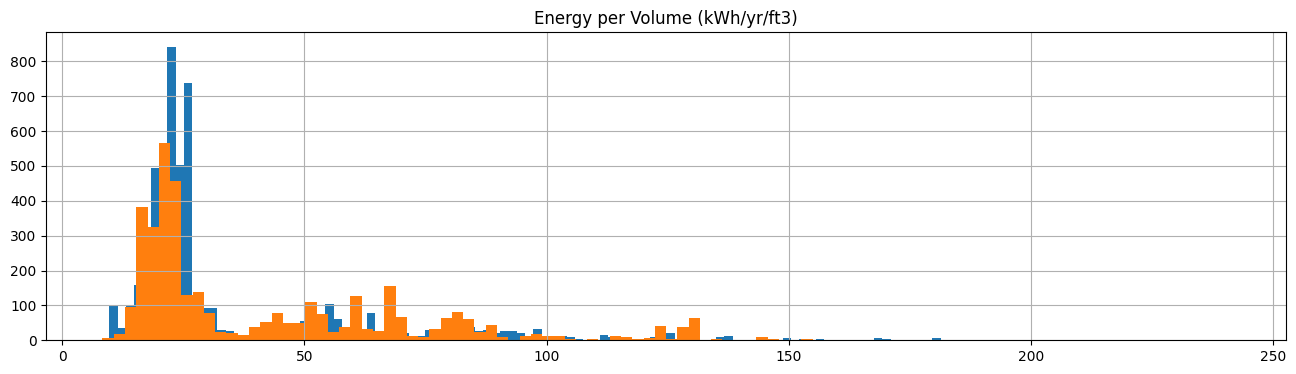

In [352]:
# plot energy_per_volume
display(doe_minus_epa['energy_per_volume'].hist(bins=100, figsize=(16, 4))) # blue
display(epa['energy_per_volume'].hist(bins=100, figsize=(16, 4))) # orange

# add title
plt.title('Energy per Volume (kWh/yr/ft3)')

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Energy per Volume (kWh/yr/ft3)')

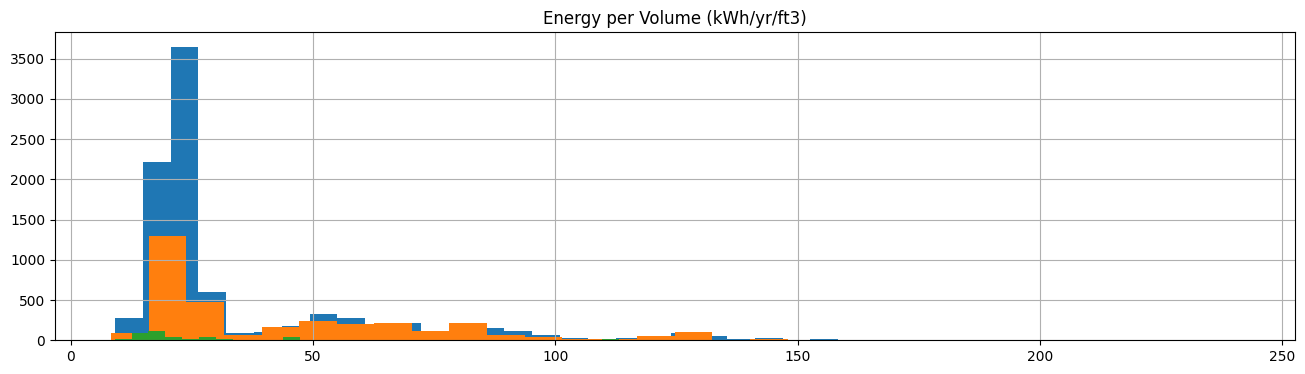

In [353]:
# plot energy_per_volume
display(doe_ref['energy_per_volume'].hist(bins=30, figsize=(16, 4))) # blue
display(epa_ref['energy_per_volume'].hist(bins=30, figsize=(16, 4))) # orange
display(epa_freeze['energy_per_volume'].hist(bins=30, figsize=(16, 4))) # green

# add title
plt.title('Energy per Volume (kWh/yr/ft3)')

In [354]:
epa_compact = epa[epa['Compact']=="Yes"]
epa_standard = epa[epa['Compact']=="No"]

In [355]:
doe_mepa_compact = doe_minus_epa[(doe_minus_epa['Product_Group_Code_Description_s'].str.lower().str.contains('compact'))&(~doe_minus_epa['Product_Group_Code_Description_s'].str.lower().str.contains('except'))]
doe_mepa_standard = doe_minus_epa[~doe_minus_epa['Product_Group_Code_Description_s'].str.lower().str.contains('compact')&(~doe_minus_epa['Product_Group_Code_Description_s'].str.lower().str.contains('except'))]

In [356]:
print("Percentage of compact refrigerators from ENERGY STAR database:", round(len(epa_compact)/len(epa), 2))
print("Percentage of compact refrigerators from DOE database ", round(len(doe_mepa_compact)/len(doe_minus_epa), 2))

Percentage of compact refrigerators from ENERGY STAR database: 0.43
Percentage of compact refrigerators from DOE database  0.3


In [357]:
print("Percentage of standard refrigerators from ENERGY STAR database:", round(len(epa_standard)/len(epa), 2))
print("Percentage of standard refrigerators from ENERGY STAR database:", round(len(doe_mepa_standard)/len(doe_minus_epa), 2))

Percentage of standard refrigerators from ENERGY STAR database: 0.57
Percentage of standard refrigerators from ENERGY STAR database: 0.66


## ALL

In [358]:
print(f"The average energy per volume for EPA refrigerators is {epa.energy_per_volume.mean():.2f} kWh/yr/ft3")
display(epa.energy_per_volume.describe())

print(f"The average energy per volume for DOE refrigerators is {doe_minus_epa.energy_per_volume.mean():.2f} kWh/yr/ft3")
display(doe_minus_epa.energy_per_volume.describe())

The average energy per volume for EPA refrigerators is 42.67 kWh/yr/ft3


count    3786.000000
mean       42.665545
std        31.309679
min         8.324607
25%        20.391304
50%        24.978632
75%        61.136364
max       241.000000
Name: energy_per_volume, dtype: float64

The average energy per volume for DOE refrigerators is 36.00 kWh/yr/ft3


count    5527.000000
mean       36.003430
std        28.215573
min         9.726027
25%        20.368421
50%        24.349206
75%        39.939124
max       181.333333
Name: energy_per_volume, dtype: float64

<Axes: >

<Axes: >

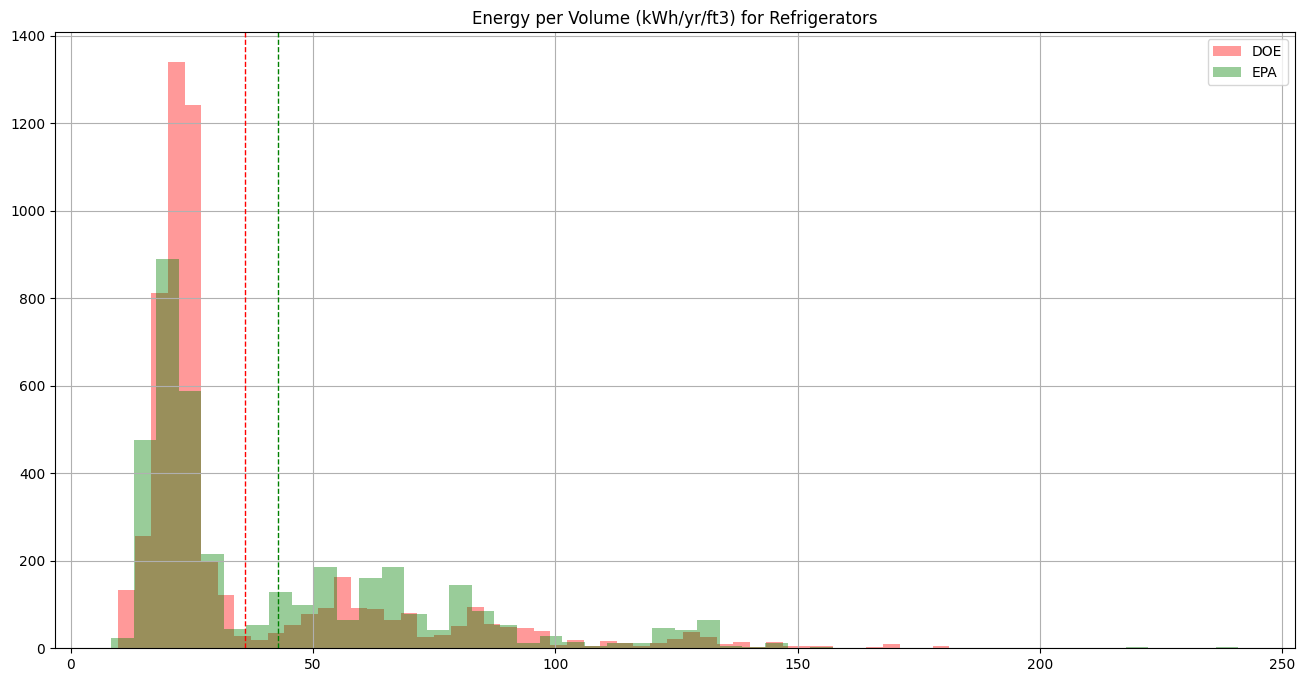

In [359]:
# Plot energy per volume for standard refrigerators
display(doe_minus_epa['energy_per_volume'].hist(bins=50, figsize=(16, 8), color='red', alpha=0.4, label='DOE'))
display(epa['energy_per_volume'].hist(bins=50, figsize=(16, 8), color='green', alpha=0.4, label='EPA'))

# Add title
plt.title('Energy per Volume (kWh/yr/ft3) for Refrigerators')

# Add legend
plt.legend()

# Add average lines
plt.axvline(doe_minus_epa.energy_per_volume.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(epa.energy_per_volume.mean(), color='green', linestyle='dashed', linewidth=1)

In [360]:
more_energy_than_doe_average = epa[epa['Annual Energy Use (kWh/yr)'] > doe_minus_epa['Annual_Energy_Use__Kilowatt_Hours_Year__d'].mean()]['Model Number'].count()/epa['Model Number'].count()

print(f"{more_energy_than_doe_average:.2%} of EPA refrigerators use more energy per volume than the average DOE refrigerator.")

31.25% of EPA refrigerators use more energy per volume than the average DOE refrigerator.


In [361]:
doe_minus_epa.energy_per_volume.mean()

36.00342962475794

## Standard

In [362]:
print(f"The average energy per volume for EPA standard refrigerators is {epa_standard.energy_per_volume.mean():.2f} kWh/yr/ft3")
display(epa_standard.energy_per_volume.describe())

print(f"The average energy per volume for DOE standard refrigerators is {doe_mepa_standard.energy_per_volume.mean():.2f} kWh/yr/ft3")
display(doe_mepa_standard.energy_per_volume.describe())

The average energy per volume for EPA standard refrigerators is 21.38 kWh/yr/ft3


count    2150.000000
mean       21.380316
std         4.859461
min         8.324607
25%        18.111111
50%        21.307096
75%        23.864542
max        80.666667
Name: energy_per_volume, dtype: float64

The average energy per volume for DOE standard refrigerators is 22.46 kWh/yr/ft3


count    3670.000000
mean       22.459583
std         3.837722
min        10.758808
25%        19.323671
50%        22.500000
75%        25.224490
max        49.468085
Name: energy_per_volume, dtype: float64

<Axes: >

<Axes: >

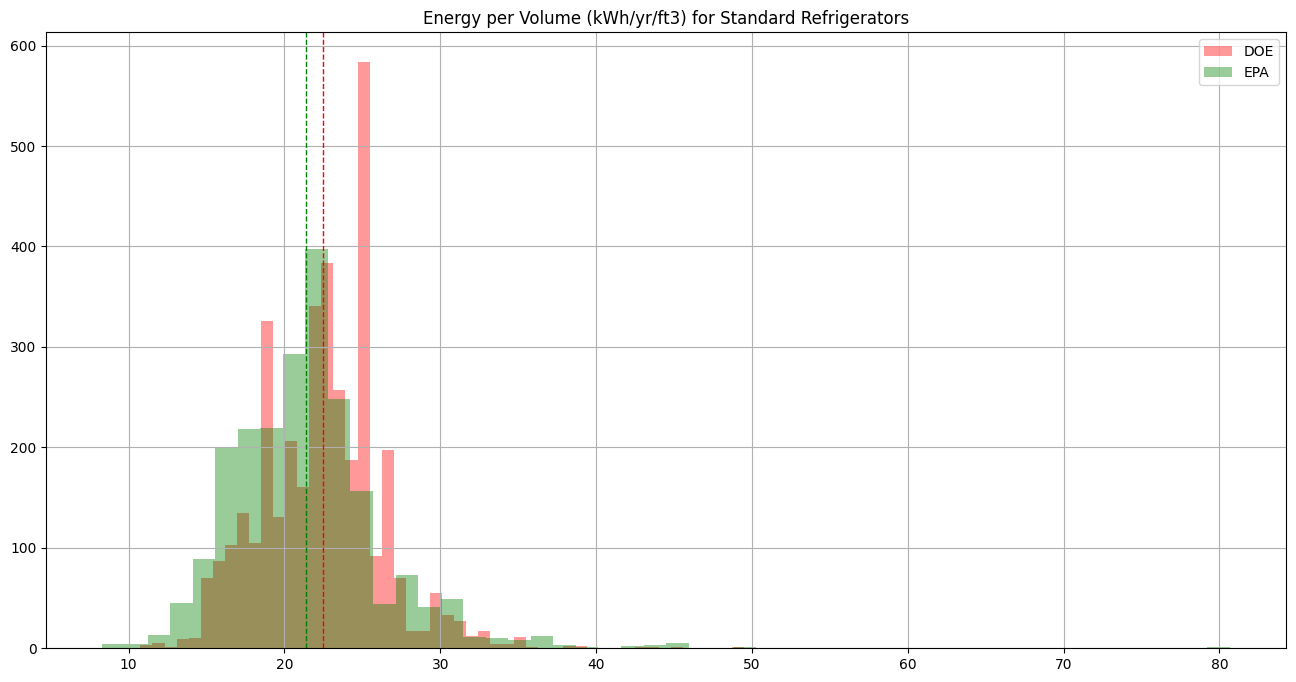

In [363]:
# Plot energy per volume for standard refrigerators
display(doe_mepa_standard['energy_per_volume'].hist(bins=50, figsize=(16, 8), color='red', alpha=0.4, label='DOE'))
display(epa_standard['energy_per_volume'].hist(bins=50, figsize=(16, 8), color='green', alpha=0.4, label='EPA'))

# Add title
plt.title('Energy per Volume (kWh/yr/ft3) for Standard Refrigerators')

# Add legend
plt.legend()

# Add average lines
plt.axvline(doe_mepa_standard.energy_per_volume.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(epa_standard.energy_per_volume.mean(), color='green', linestyle='dashed', linewidth=1)

In [364]:
more_energy_than_doe_average_standard = epa_standard[epa_standard.energy_per_volume > doe_mepa_standard.energy_per_volume.mean()]['Model Number'].count()/epa_standard['Model Number'].count()

print(f"{more_energy_than_doe_average_standard:.2%} of EPA standard refrigerators use more energy per volume than the average DOE standard refrigerator.")

33.26% of EPA standard refrigerators use more energy per volume than the average DOE standard refrigerator.


## Compact

In [365]:
print(f"The average energy per volume for EPA compact refrigerators is {epa_compact.energy_per_volume.mean():.2f} kWh/yr/ft3")
display(epa_compact.energy_per_volume.describe())

print(f"The average energy per volume for DOE compact refrigerators is {doe_mepa_compact.energy_per_volume.mean():.2f} kWh/yr/ft3")
display(doe_mepa_compact.energy_per_volume.describe())

The average energy per volume for EPA compact refrigerators is 70.64 kWh/yr/ft3


count    1636.000000
mean       70.638186
std        29.319220
min        16.097561
25%        51.363636
50%        66.666667
75%        82.692308
max       241.000000
Name: energy_per_volume, dtype: float64

The average energy per volume for DOE compact refrigerators is 68.38 kWh/yr/ft3


count    1672.000000
mean       68.380928
std        32.938069
min        15.447154
25%        49.642857
50%        63.133929
75%        85.600000
max       181.333333
Name: energy_per_volume, dtype: float64

<Axes: >

<Axes: >

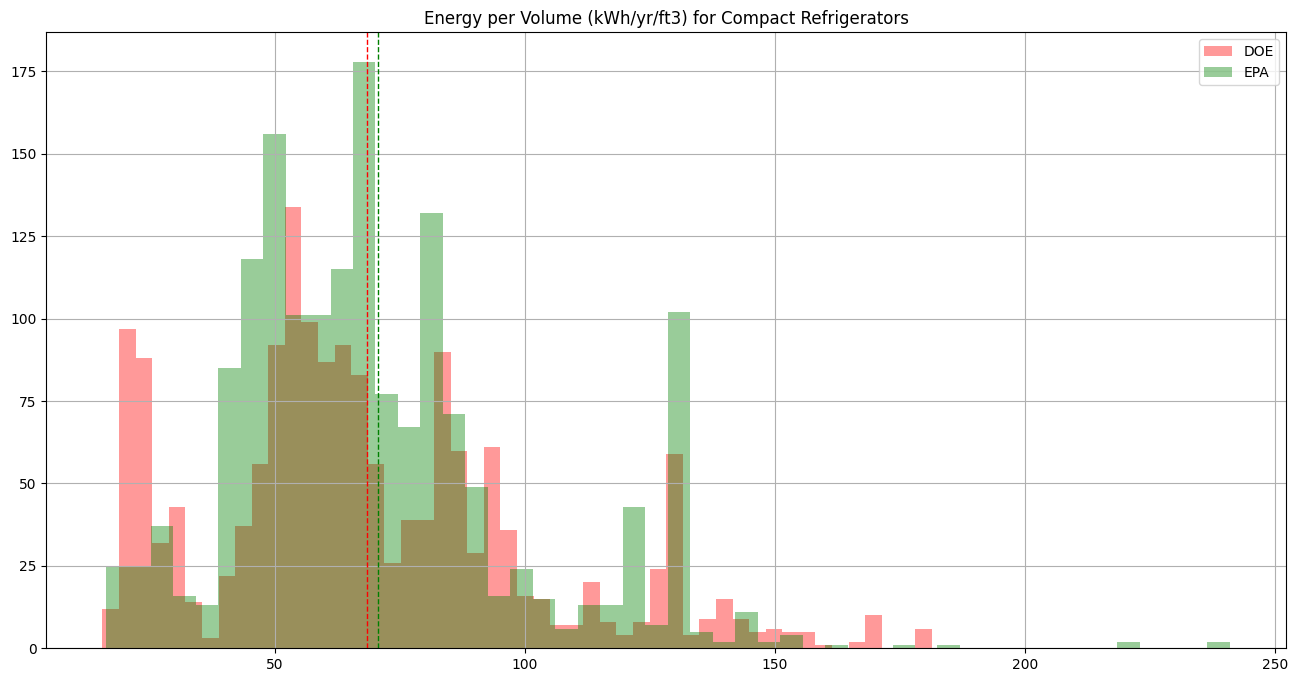

In [366]:
display(doe_mepa_compact['energy_per_volume'].hist(bins=50, figsize=(16, 8), color='red', alpha=0.4, label='DOE'))
display(epa_compact['energy_per_volume'].hist(bins=50, figsize=(16, 8), color='green', alpha=0.4, label='EPA'))


# Add title
plt.title('Energy per Volume (kWh/yr/ft3) for Compact Refrigerators')

# Add legend
plt.legend()

# Add average lines
plt.axvline(doe_mepa_compact.energy_per_volume.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(epa_compact.energy_per_volume.mean(), color='green', linestyle='dashed', linewidth=1)

In [367]:
more_energy_than_doe_average_compact = epa_compact[epa_compact.energy_per_volume > doe_mepa_compact.energy_per_volume.mean()]['Model Number'].count()/epa_compact['Model Number'].count()

print(f"{more_energy_than_doe_average_compact:.2%} of EPA compact refrigerators use more energy per volume than the average DOE compact refrigerator.")

42.85% of EPA compact refrigerators use more energy per volume than the average DOE compact refrigerator.


In [368]:
epa.sort_values(by="energy_per_volume", ascending=False).head(10)

,Product Class,Model Number,Annual Energy Use (kWh/yr),Adjusted Volume (ft3),Compact,energy_per_volume,code,adj_volume,annual_energy_use,regexed_model_no
515,13A - Compact All-Refrigerators - automatic de...,DAR010A1*,241,1.0,Yes,241.000000,13A,1.0,241.0,DAR010A1.
2485,13A - Compact All-Refrigerators - automatic de...,BC29,241,1.0,Yes,241.000000,13A,1.0,241.0,BC29
53,13A - Compact All-Refrigerators - automatic de...,ARD104AB14R/L,242,1.1,Yes,220.000000,13A,1.1,242.0,ARD104AB14R/L
54,13A - Compact All-Refrigerators - automatic de...,ARD104AB21R/L,242,1.1,Yes,220.000000,13A,1.1,242.0,ARD104AB21R/L
477,13A - Compact All-Refrigerators - automatic de...,EFBX100,243,1.3,Yes,186.923077,13A,1.3,243.0,EFBX100
3321,13A - Compact All-Refrigerators - automatic de...,FAB5UL*#,210,1.2,Yes,175.000000,13A,1.2,210.0,FAB5UL..
1381,13A - Compact All-Refrigerators - automatic de...,LCR17D6NBE,245,1.5,Yes,163.333333,13A,1.5,245.0,LCR17D6NBE
1386,13A - Compact All-Refrigerators - automatic de...,LMS016M6RBE,246,1.6,Yes,153.750000,13A,1.6,246.0,LMS016M6RBE
518,13A - Compact All-Refrigerators - automatic de...,DAR016B1BM-6,245,1.6,Yes,153.125000,13A,1.6,245.0,DAR016B1BM-6
516,13A - Compact All-Refrigerators - automatic de...,DAR016A1*,245,1.6,Yes,153.125000,13A,1.6,245.0,DAR016A1.


### Export Analysis Results as CSV

In [369]:
print(len(epa))
print(len(epa_standard))
print(len(epa_compact))
print(len(doe_ref))
print(len(doe_minus_epa))
print(len(doe_mepa_standard))
print(len(doe_mepa_compact))

epa.to_csv('analysis/epa.csv', index=False)
epa_standard.to_csv('analysis/epa_standard.csv', index=False)
epa_compact.to_csv('analysis/epa_compact.csv', index=False)
doe_ref.to_csv('analysis/doe_ref.csv', index=False)
doe_minus_epa.to_csv('analysis/doe_minus_epa.csv', index=False)
doe_mepa_compact.to_csv('analysis/doe_mepa_compact.csv', index=False)
doe_mepa_standard.to_csv('analysis/doe_mepa_standard.csv', index=False)

3786
2150
1636
9067
5527
3670
1672


# Multivariable Regression

In [370]:
epa = epa[[
    'code',
    'regexed_model_no',
    'Compact',
    'energy_per_volume',
    'adj_volume',
    'annual_energy_use',
]]

epa['source'] = 'epa'

In [371]:
doe_minus_epa['code'] =  doe_minus_epa['Product_Group_Code_Description_s'].str.split(".").str[0].str[1:]
doe_minus_epa['Compact'] = (doe_minus_epa['Product_Group_Code_Description_s'].str.lower().str.contains('compact')) & (~doe_minus_epa['Product_Group_Code_Description_s'].str.lower().str.contains('except'))
doe_minus_epa['Compact'] = doe_minus_epa['Compact'].replace({True: 'Yes', False: 'No'})

In [372]:
doe_minus_epa = doe_minus_epa[[
    'code',
    'Compact',
    'source',
    'regexed_model_no',
    'energy_per_volume',
    'adj_volume',
    'annual_energy_use',
]]

doe_minus_epa

,code,Compact,source,regexed_model_no,energy_per_volume,adj_volume,annual_energy_use
3,13A,Yes,doe,RC33A1GWE,78.787879,3.3,260.0
13,11A,Yes,doe,EFR176-BLUE-6COM,125.000000,1.6,200.0
15,11A,Yes,doe,EFR176-C-BLACK_AMZ,125.000000,1.6,200.0
21,11A,Yes,doe,EFR376-B-RED-6COM,69.354839,3.1,215.0
22,11A,Yes,doe,EFR376-BLACK-6COM,69.354839,3.1,215.0
...,...,...,...,...,...,...,...
9320,11A,Yes,doe,BCRK25V,95.600000,2.5,239.0
9322,11A,Yes,doe,BCRK17W,136.470588,1.7,232.0
9323,11A,Yes,doe,PS-RF739-I6A,68.437500,3.2,219.0
9324,3,No,doe,BCD290,27.355372,12.1,331.0


In [373]:
# Combine EPA and DOE datasets
data = pd.concat([epa, doe_minus_epa])
data

,code,regexed_model_no,Compact,energy_per_volume,adj_volume,annual_energy_use,source
0,3,2ATMW212E,No,15.468750,25.6,396.0,epa
1,11A,2AW1BF26A,Yes,82.692308,2.6,215.0,epa
2,11A,2AW1SLF44A,Yes,51.818182,4.4,228.0,epa
3,5,ABM.171E,No,21.578947,20.9,451.0,epa
4,5,ABM.171E.,No,21.578947,20.9,451.0,epa
...,...,...,...,...,...,...,...
9320,11A,BCRK25V,Yes,95.600000,2.5,239.0,doe
9322,11A,BCRK17W,Yes,136.470588,1.7,232.0,doe
9323,11A,PS-RF739-I6A,Yes,68.437500,3.2,219.0,doe
9324,3,BCD290,No,27.355372,12.1,331.0,doe


In [374]:
%%R

# T test between Energy Star and non-Energy Star refrigerators
# !!!

model <- t.test(energy_per_volume ~ source, data = data)

print(model)

	Welch Two Sample t-test

data:  energy_per_volume by source
t = -10.495, df = 7564.2, p-value < 2.2e-16
alternative hypothesis: true difference in means between group doe and group epa is not equal to 0
95 percent confidence interval:
 -7.906495 -5.417735
sample estimates:
mean in group doe mean in group epa 
         36.00343          42.66554 



In [376]:
%%R

# According to the model below, when controlling for volume, energy star certified refrigerators use less energy than non energy star certified models.

model <- lm(annual_energy_use ~ adj_volume + factor(source), data=data)
summary(model)


Call:
lm(formula = annual_energy_use ~ adj_volume + factor(source), 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-357.96  -57.20    4.98   56.85  315.68 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       199.25827    1.92316  103.61   <2e-16 ***
adj_volume         13.34945    0.08443  158.10   <2e-16 ***
factor(source)epa -20.16050    1.82123  -11.07   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 85.23 on 9310 degrees of freedom
Multiple R-squared:  0.7389,	Adjusted R-squared:  0.7388 
F-statistic: 1.317e+04 on 2 and 9310 DF,  p-value: < 2.2e-16



`geom_smooth()` using formula = 'y ~ x'


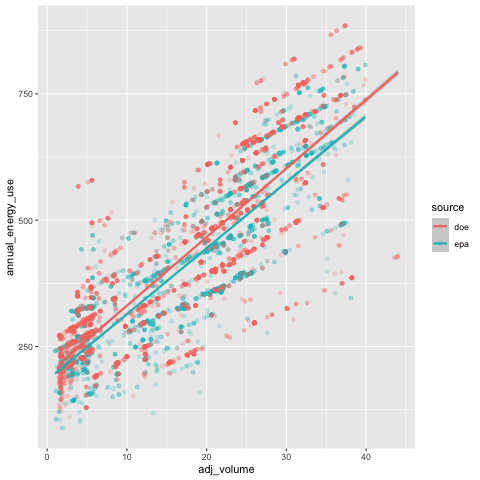

In [404]:
%%R

ggplot(data, aes(x=adj_volume, y=annual_energy_use, color=source)) +
    geom_point(alpha=0.2) +
    geom_smooth(method=lm)

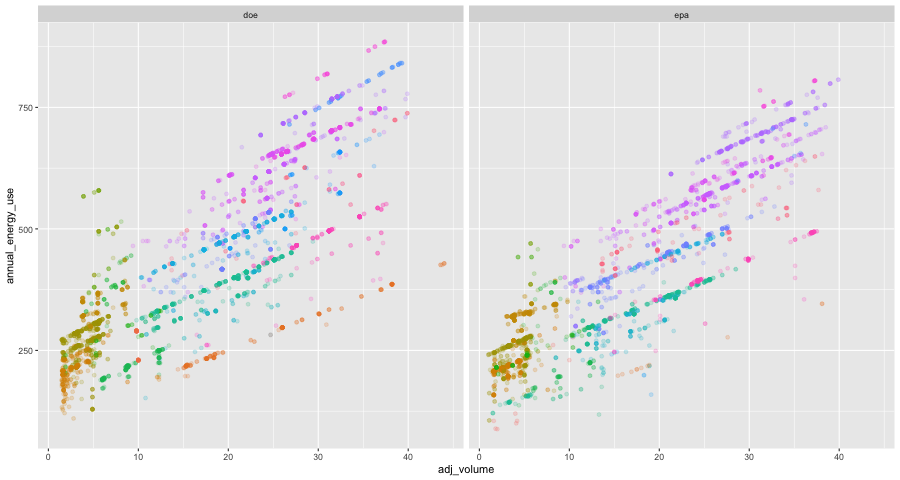

In [402]:
%%R -w 900

# model <- lm(annual_energy_use ~ adj_volume + factor(source), data=data)

ggplot(data, aes(x=adj_volume, y=annual_energy_use, color=code)) +
    geom_point(alpha=0.2) +
    # geom_smooth(method=lm) +
    facet_wrap(~source) +
    theme(legend.position="none")

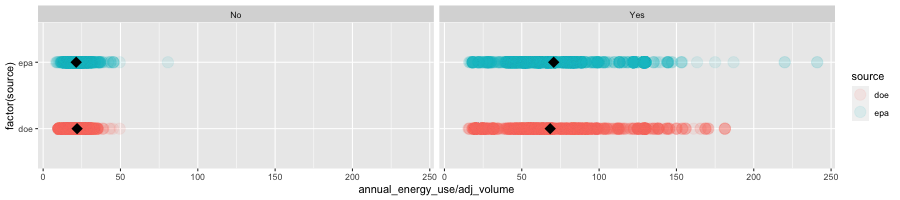

In [388]:
%%R -h 200 -w 900

ggplot(data, aes(x=annual_energy_use/adj_volume, y=factor(source), color=source)) +
    geom_point(size=5, alpha=0.1) +
    stat_summary(fun.y=mean, geom="point", size=5, shape=18, color="black") +
    facet_wrap(~Compact)

In [389]:
%%R

model <- t.test(energy_per_volume ~ source, data = data %>% filter(Compact == "Yes"))

print(model)


	Welch Two Sample t-test

data:  energy_per_volume by source
t = -2.083, df = 3276.9, p-value = 0.03733
alternative hypothesis: true difference in means between group doe and group epa is not equal to 0
95 percent confidence interval:
 -4.381971 -0.132546
sample estimates:
mean in group doe mean in group epa 
         68.38093          70.63819 



In [390]:
%%R

model <- t.test(energy_per_volume ~ source, data = data %>% filter(Compact == "No"))

print(model)


	Welch Two Sample t-test

data:  energy_per_volume by source
t = 4.5976, df = 4061, p-value = 4.404e-06
alternative hypothesis: true difference in means between group doe and group epa is not equal to 0
95 percent confidence interval:
 0.3328223 0.8277097
sample estimates:
mean in group doe mean in group epa 
         21.96058          21.38032 



# Brand Analysis

In [381]:
epa_all = pd.read_csv('input_data/epa_residential_refrigerators.csv', dtype={'ENERGY STAR Unique ID': str}).drop_duplicates()

epa_all = epa_all[[
    'Brand Name',
    'Product Class',
    'Model Number',
    'Annual Energy Use (kWh/yr)',
    'Adjusted Volume (ft3)',
    'Compact'
]].drop_duplicates()

In [382]:
epa_all['energy_per_volume'] = epa_all['Annual Energy Use (kWh/yr)'] / epa_all['Adjusted Volume (ft3)']

In [383]:
epa_all.groupby('Brand Name').mean('energy_per_volume').sort_values('energy_per_volume', ascending=False)['energy_per_volume'].reset_index().head(10)

,Brand Name,energy_per_volume
0,ECOFLOW,186.923077
1,Mini Bar,156.871795
2,White-Westinghouse,129.375000
3,RVISION,111.149733
4,DOMETIC,106.799366
5,Danby or Danby Designer,103.929924
6,Willz,103.225806
7,IGLOO,100.355240
8,Antarctic Star,99.218750
9,Lorell,98.402778


In [384]:
epa_all.groupby('Brand Name').mean('energy_per_volume').sort_values('energy_per_volume', ascending=True)['energy_per_volume'].reset_index().head(10)

,Brand Name,energy_per_volume
0,Asko,9.599462
1,Gallery,15.121951
2,True Residential,15.583756
3,CTM,16.086957
4,SANKEY,16.272111
5,Gladiator,16.460674
6,Conservator,16.705643
7,Elisii,16.831513
8,L2,16.860455
9,QG QUALITY GLOBAL,17.203791


In [385]:
(
    epa_all[
        epa_all['Brand Name']
              .str.lower()
              .isin(['samsung', 'lg', 'ge', 'frigidaire', 'whirlpool', 'kenmore'])
    ]
    .groupby('Brand Name')
    .mean('energy_per_volume').sort_values('energy_per_volume', ascending=False).head(10)
)

,Annual Energy Use (kWh/yr),Adjusted Volume (ft3),energy_per_volume
Brand Name,,,
Frigidaire,387.685714,15.598286,51.480984
Kenmore,463.553846,20.330769,35.816890
Whirlpool,464.136842,19.411579,34.460216
GE,505.413333,24.355333,22.177422
LG,584.260870,27.720870,21.609929
Samsung,615.604651,29.672093,21.019838


In [386]:
epa_efficiency_by_code = epa.groupby('Product Class')['energy_per_volume'].mean().reset_index()
epa_count_by_code = epa.groupby('Product Class')['Model Number'].count().reset_index()

epa_efficiency_by_code = epa_efficiency_by_code.merge(epa_count_by_code, on='Product Class')

KeyError: 'Product Class'

In [ ]:
epa_efficiency_by_code.sort_values('energy_per_volume', ascending=False).to_csv('analysis/epa_efficiency_by_code.csv', index=False)

In [ ]:
doe_efficiency_by_code = doe_minus_epa.groupby('Product_Group_Code_Description_s')['energy_per_volume'].mean().reset_index()
doe_count_by_code = doe_minus_epa.groupby('Product_Group_Code_Description_s')['Individual_Model_Number_Covered_by_Basic_Model_m'].count().reset_index()

doe_efficiency_by_code = doe_efficiency_by_code.merge(doe_count_by_code, on='Product_Group_Code_Description_s')

doe_efficiency_by_code.sort_values('energy_per_volume', ascending=False)

# Get sum of model counts
doe_efficiency_by_code['Individual_Model_Number_Covered_by_Basic_Model_m'].sum()

5527

In [ ]:
doe_efficiency_by_code.sort_values('energy_per_volume', ascending=False).to_csv('analysis/doe_efficiency_by_code.csv', index=False)

NULL
